# Nonlinear Damped Pendulum

$$
mL\dfrac{d^2 \theta}{d t^2} + \beta L \dfrac{d \theta}{d t} + mg\sin(\theta) = 0~,
$$

or

$$
\dfrac{d^2 \theta}{d t^2} + b \dfrac{d \theta}{d t} + \omega_0^2\sin(\theta) = 0~,
$$

where            $\omega_0^2 = \frac{g}{L}$, $b = \frac{\beta}{m}$

with the initial conditions
$$
\theta(0) = \pi/4~~,~~\dfrac{d \theta}{d t}(0) = 0~.

In [117]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [118]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

## Generate training data

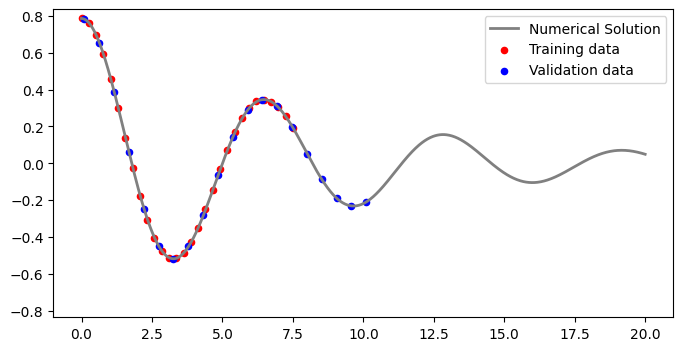

In [119]:
# Parameters and initial conditions
# w0^2 = g/L, 

w0 = 1
b  = 0.25

X0 = [np.pi/4, 0]

# time domain
ti = 0
tf = 20
N  = 1000

t = torch.linspace(ti, tf, N).view(-1,1)

# Numerical Solution
def ODE(X, t):
    dXdt = [X[1], -w0*np.sin(X[0]) - b*X[1]]
    return dXdt

solution = odeint(ODE, X0, t.numpy().flatten())
x        = torch.from_numpy(solution[:,0]).view(-1,1)
dx       = torch.from_numpy(solution[:,1]).view(-1,1)
x_max    = torch.max(torch.abs(x))

solution.dtype = np.double

# Pick a few points from the left hand side to be training data
t_data  = torch.linspace(0, 7.5, 30).view(-1,1)
x_data  = x[torch.searchsorted(t.flatten(), t_data.flatten())]
dx_data = dx[torch.searchsorted(t.flatten(), t_data.flatten())]

# Pick a few points for validation
t_val  = torch.linspace(0.1, 10.1, 20).view(-1,1)
x_val  = x[torch.searchsorted(t.flatten(), t_val.flatten())]
dx_val = dx[torch.searchsorted(t.flatten(), t_val.flatten())]

plt.figure(figsize=(8,4))

plt.plot(t, solution[:,0], label="Numerical Solution", color='grey', lw=2, alpha=1, linestyle='-')
plt.scatter(t_data, x_data, color="red", label="Training data", s=20)
plt.scatter(t_val, x_val, color="blue", label="Validation data", s=20)
plt.ylim(-x_max-.05, x_max+0.05)
plt.legend()
plt.show()

In [120]:
# Plotting Function

def plot_result(i, t, x, t_data, x_data, u, tp=None, vt=None, vp=None):
    """
    Plots pretty plots
    """
    
    plt.plot(t, x,  color="grey", linewidth=2, alpha=1, label="solution")
    plt.plot(t, u, color="black", linewidth=3, alpha=0.8, label="Neural network prediction")
    plt.scatter(t_data, x_data, s=20, color="red", alpha=0.6, label='Training data')
    if vt is not None:
        plt.scatter(vt, vp, s=20, color="blue", alpha=0.6, label='Validation data')
    if tp is not None:
        plt.scatter(tp, -0*torch.ones_like(tp), s=10, color="green", alpha=0.6, label='Physics loss training locations')
        
    l = plt.legend(loc=(1.01, 0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(ti-0.1, tf+0.1)
    plt.ylim(-x_max*(1+0.1), x_max*(1+0.1))
    plt.text(x_max, 0.7*x_max*(1+1),"Training step: %i"%(i),fontsize="xx-large",color="k")
    plt.axis("off")

## PINN

In [121]:
# Define the sample locations for physics loss
t_physics  = torch.linspace(0, tf, 50).view(-1,1).requires_grad_(True)

# Define the samle locations for training data
t_training  = t_data.clone().requires_grad_(True)

# Define the sample locations for validation
t_validation = t_val.clone().requires_grad_(True)

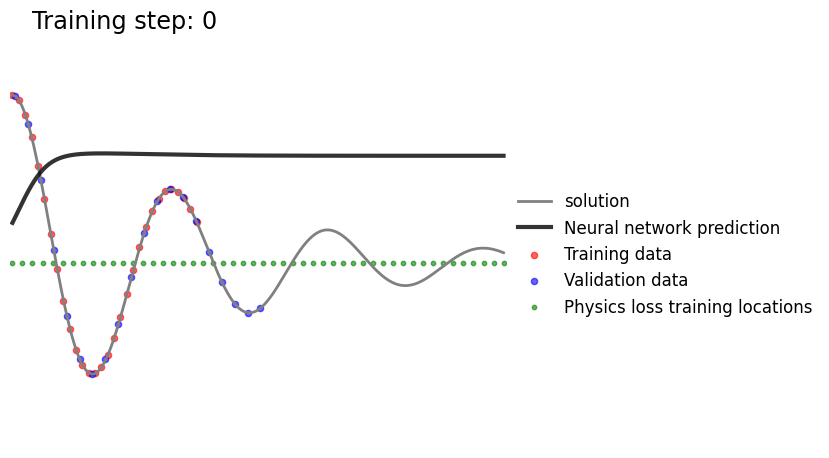

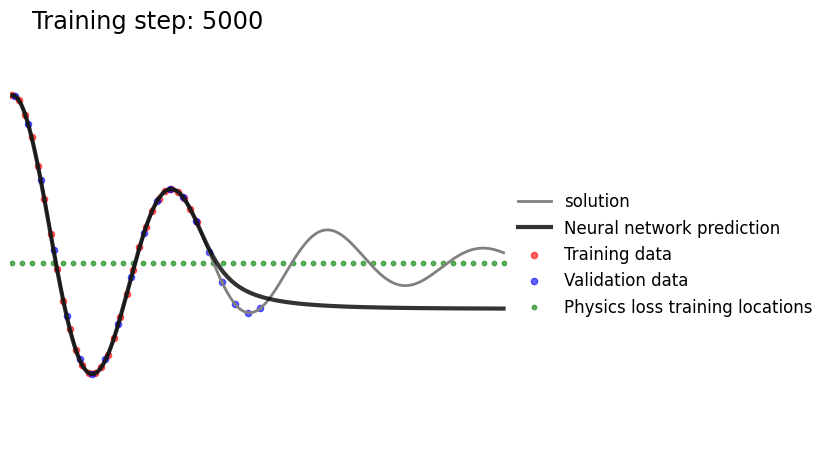

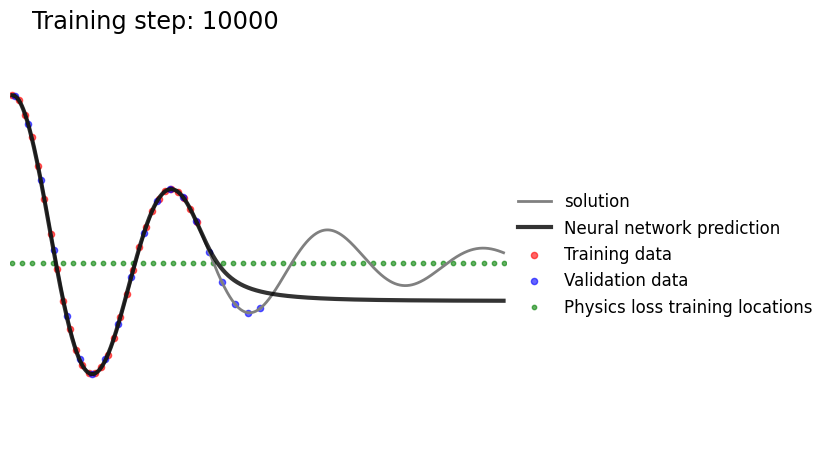

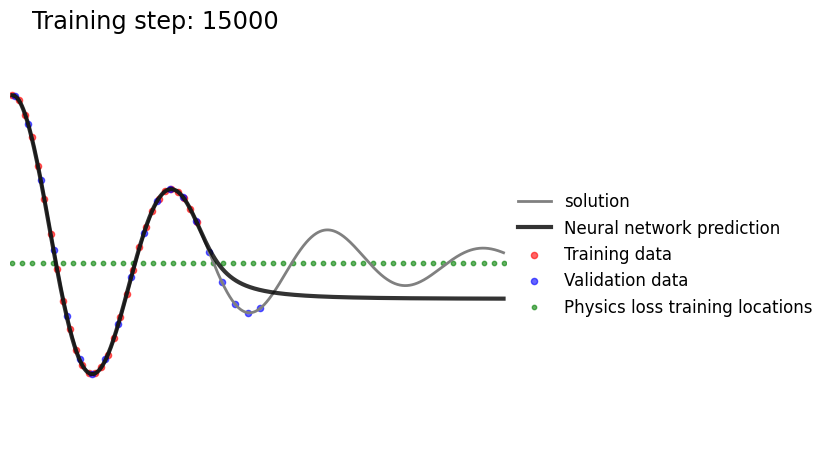

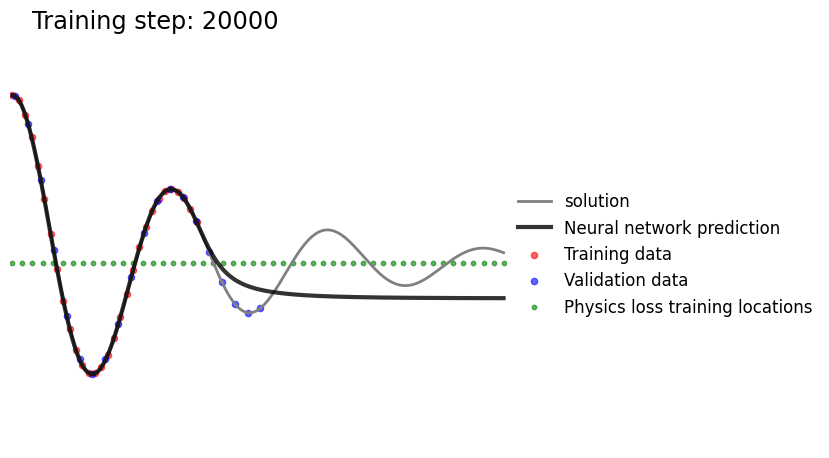

In [ ]:
# PINN

torch.manual_seed(123)

# Define PINN model. 1 input, 1 output, 3 hidden layers of 32 nodes.
PINN = FCN(1, 1, 32, 3)

# Uses the Adam optimizer
optimizer = torch.optim.Adam(PINN.parameters(), lr = 1e-4)

# Exponential scheduler, multiplies learning rate (lr) by gamma every 1000 epochs
# set gamma to 1 to basically disable
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

# Number of training steps
epochs = 20_000 + 1

# Weights for loss function
w1 = 1e-1 # weight for data loss
w2 = 1e-4 # weight for physics loss

# used for making the gif
files = []

# stores loss values
training_loss   = []
validation_loss = []


for i in range(epochs):
    # ===
    # Training
    # ===
    
    PINN.train()
    optimizer.zero_grad()
    
    # Compute data loss for position
    u = PINN(t_training)
    loss_position = torch.mean((u - x_data)**2)
    
    # Compute data loss for velocity
    du = torch.autograd.grad(u, t_training, torch.ones_like(u), create_graph=True)[0]
    loss_velocity = torch.mean((du - dx_data)**2)
    
    # Compute the physics loss
    v   = PINN(t_physics)
    dv  = torch.autograd.grad(v, t_physics, torch.ones_like(v), create_graph=True)[0]
    d2v = torch.autograd.grad(dv,  t_physics, torch.ones_like(dv),  create_graph=True)[0]
    physics = d2v + b*dv + (w0**2)*torch.sin(v) 
    loss_ODE = torch.mean(physics**2)
    
    # Compute total loss
    loss = loss_position + w1*loss_velocity + w2*loss_ODE
    training_loss.append(loss.detach())
    
    # Backpropagate the loss
    loss.backward()
    
    # Update the training weights
    optimizer.step()
    
    # every 1000 epochs, multiply learning rate by gamma
    if (i+1) % 1000 == 0: scheduler.step()
    
    # ===
    # Validation
    # ===
    
    PINN.eval()

    u_val = PINN(t_validation)
    loss_position_val = torch.mean((u_val - x_val)**2)
    
    du_val = torch.autograd.grad(u_val, t_validation, torch.ones_like(u_val), create_graph=True)[0]
    loss_velocity_val = torch.mean((du_val - dx_val)**2)
    
    v_val  = PINN(t_validation)
    dv_val  = torch.autograd.grad(v_val, t_validation, torch.ones_like(v_val), create_graph=True)[0]
    d2v_val = torch.autograd.grad(dv_val,  t_validation, torch.ones_like(dv_val),  create_graph=True)[0]
    physics_val = d2v_val + b*dv_val + (w0**2)*torch.sin(v_val) 
    loss_ODE_val = torch.mean(physics_val**2)
    
    loss_val = loss_position_val + w1*loss_velocity_val + w2*loss_ODE_val
    validation_loss.append(loss_val.detach())
    
    # ===
    # Plotting
    # ===
    
    if (i % 200) == 0: 
        u = PINN(t).detach()
        tp = t_physics.detach()
        
        plot_result(i, t, x, t_data, x_data, u, tp, t_val, x_val)
        
        file = "plots/PINN_Nonlinear_Pendulum_%.8i.png"%(i)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        if (i % 5_000) == 0: plt.show()
        else: plt.close("all")
            
save_gif_PIL("gifs/PINN_Nonlinear_Pendulum.gif", files, fps=20, loop=0)

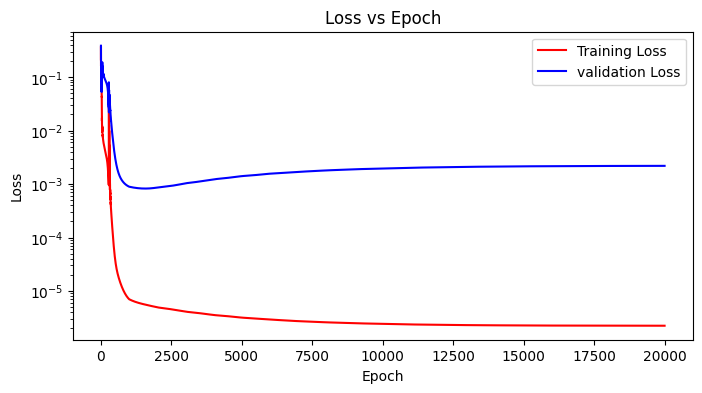

In [144]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(epochs), training_loss, label='Training Loss', color='red')
plt.plot(np.arange(epochs), validation_loss, label='validation Loss',color='blue')

plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale('log')
plt.legend()
plt.show()